## Formulation
Lets say you have two vector valued random variables $x$ and $y$ with some joint density $p(x,y)$.  Assume you can generate samples of $(x,y)$.

Let $r_i^{(k)}$ denote component $i$ of the random variable $r$ in layer $k$ of the normalizing flow.   Using a RealNVP approach, each layer of the transformation takes the form
$$
\left[\begin{array}{c}r_{0:d}^{(k+1)}\\ r_{d+1:D}^{(k+1)} \end{array}\right] = P\left[\begin{array}{c}r_{0:d}^{(k)}\\ b\left(r_{0:d}^{(k)}\right) + s\left(r_{0:d}^{(k)}\right)r_{d+1:D}^{(k)} \end{array}\right],
$$
where $P$ is a permutation matrix.

In [1]:
%matplotlib inline

import logging
logging.getLogger('tensorflow').disabled = True

import sys
sys.path.append("../../TransportNets")

import numpy as np
import matplotlib.pyplot as plt; plt.style.use('ggplot')

import tensorflow as tf
import tensorflow_probability as tfp

from Models.NVP import NVP
from Probability.Distributions import RotatedBanana
from Probability.MCMC import MH2d

tfd = tfp.distributions
tfb = tfp.bijectors

## Train the Normalizing Flow
First, we train the flow to map a double banana distribution to a guassian. The end goal is to perform conditional sampling using MCMC along a part of the distribution where we cross 2 different 'modes'. 

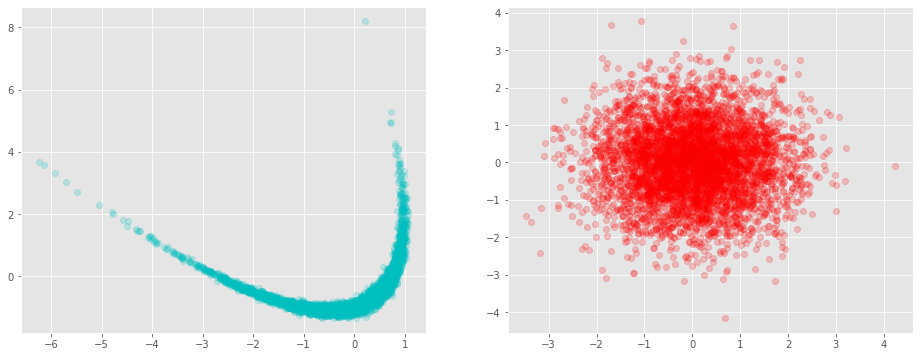

In [2]:
# Distrubtion that we want to learn to map to gaussian 
num_samples = 5000

target_2d = RotatedBanana(num_samples, 25.0, start_height = -1)
noise = tf.random.normal([num_samples],mean=0.0,stddev=0.001)
#tgt_y = tgt_x**2 + tf.random.normal([num_samples],mean=0.0,stddev=0.5)
target_3d = tf.stack([target_2d[:,1], target_2d[:,0], target_2d[:,1]+noise], axis=1)

latent = tf.random.normal([num_samples,3],mean=0.0,stddev=1.0)

# Plot them
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(121); ax2 = plt.subplot(122);
ax1.plot(target_3d[:,1], target_3d[:,0], 'co', alpha = .2)
ax2.plot(latent[:,0], latent[:,1], 'ro', alpha = .2)

### Define an NVP-based normalizing flow

In [3]:
# Create model object
nvp = NVP(num_masked=2, output_dim=3, num_layers=5, neuron_list=[20,20], permutations=[[0,2,1]]*9)

# Create optimizer and compile nvp with it
opt = tf.keras.optimizers.Adam(learning_rate=5e-4, epsilon=1e-06)
nvp.compile(opt)

# Perform a forward pass to initialize variables
_ = nvp(latent)

### Print a summary of the model

In [4]:
nvp.summary()

Model: "NVP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 2,634
Trainable params: 2,634
Non-trainable params: 0
_________________________________________________________________


### Train the model using ADAM

In [5]:
# Define training options
n_epochs = 2000
batch_size = 50

# Put the target data in a format the tf likes.
dataset = tf.data.Dataset.from_tensor_slices(target_3d)
dataset = dataset.shuffle(buffer_size=5000).batch(batch_size)

# Train the model with the new callback
nvp.batch_norm_mode(True)
history = nvp.fit(dataset, epochs=n_epochs)  # Pass callback to training

# Set the training variables to not update when doing passes
nvp.batch_norm_mode(False)

Epoch 1/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: 2.1386
Epoch 2/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: 0.5656
Epoch 3/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -0.0262
Epoch 4/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -0.3956
Epoch 5/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -0.6333
Epoch 6/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -0.8906
Epoch 7/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -1.1040
Epoch 8/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -1.2871
Epoch 9/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -1.4063
Epoch 10/2000
100/100 [==============================] - 0s 5ms/step - Nega

100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.0203
Epoch 80/2000
100/100 [==============================] - 1s 5ms/step - Negative Log Likelihood: -2.9314
Epoch 81/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.0413
Epoch 82/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.0208
Epoch 83/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.0384
Epoch 84/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.0847
Epoch 85/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -2.9955
Epoch 86/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -2.5410
Epoch 87/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.0681
Epoch 88/2000
100/100 [==============================] - 1s 6ms/step - Negativ

100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.3762
Epoch 158/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.3746
Epoch 159/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.0876
Epoch 160/2000
100/100 [==============================] - 1s 5ms/step - Negative Log Likelihood: -3.0150
Epoch 161/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.3912
Epoch 162/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -2.6031
Epoch 163/2000
100/100 [==============================] - 1s 5ms/step - Negative Log Likelihood: -2.8661
Epoch 164/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -2.9981
Epoch 165/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.2068
Epoch 166/2000
100/100 [==============================] - 0s 5ms/step 

100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.2633
Epoch 236/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.1478
Epoch 237/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.3554
Epoch 238/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.2337
Epoch 239/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.3515
Epoch 240/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.1165
Epoch 241/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.3970
Epoch 242/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.4518
Epoch 243/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.3554
Epoch 244/2000
100/100 [==============================] - 0s 5ms/step 

100/100 [==============================] - 1s 5ms/step - Negative Log Likelihood: -3.5301
Epoch 313/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.4403
Epoch 314/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.5875
Epoch 315/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.2956
Epoch 316/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.1802
Epoch 317/2000
100/100 [==============================] - 1s 5ms/step - Negative Log Likelihood: -3.5148
Epoch 318/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.0307
Epoch 319/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.0129
Epoch 320/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.3661
Epoch 321/2000
100/100 [==============================] - 0s 4ms/step 

100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.5236
Epoch 391/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.5615
Epoch 392/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.4923
Epoch 393/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.2802
Epoch 394/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.6799A: 0s - Negative Log Likelihood: 
Epoch 395/2000
100/100 [==============================] - 1s 5ms/step - Negative Log Likelihood: -3.4382
Epoch 396/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.2881
Epoch 397/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.5934
Epoch 398/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.4207
Epoch 399/2000
100/100 [=============

100/100 [==============================] - 1s 5ms/step - Negative Log Likelihood: -3.7262
Epoch 468/2000
100/100 [==============================] - 1s 5ms/step - Negative Log Likelihood: -3.5474
Epoch 469/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.4169
Epoch 470/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.5313
Epoch 471/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.2941
Epoch 472/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.5980
Epoch 473/2000
100/100 [==============================] - 1s 5ms/step - Negative Log Likelihood: -3.1672
Epoch 474/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.5320
Epoch 475/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.7288
Epoch 476/2000
100/100 [==============================] - 0s 5ms/step 

100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.4143
Epoch 545/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.5394
Epoch 546/2000
100/100 [==============================] - 1s 5ms/step - Negative Log Likelihood: -3.5623
Epoch 547/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.4424
Epoch 548/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.6010
Epoch 549/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.6795
Epoch 550/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.4147
Epoch 551/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.6595
Epoch 552/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.5809
Epoch 553/2000
100/100 [==============================] - 0s 5ms/step 

100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.1482
Epoch 623/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.6124
Epoch 624/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.4502
Epoch 625/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.5950
Epoch 626/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.6203
Epoch 627/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.6961
Epoch 628/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.0252
Epoch 629/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.5707
Epoch 630/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -2.5334
Epoch 631/2000
100/100 [==============================] - 0s 5ms/step 

100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.2517
Epoch 701/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.4428
Epoch 702/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.7513
Epoch 703/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.5443
Epoch 704/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.3854
Epoch 705/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.4297
Epoch 706/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.6547
Epoch 707/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.6442
Epoch 708/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.6337
Epoch 709/2000
100/100 [==============================] - 0s 5ms/step 

100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.6914
Epoch 779/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.4892
Epoch 780/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.6253
Epoch 781/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.6147
Epoch 782/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.5002
Epoch 783/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.5879
Epoch 784/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.7716
Epoch 785/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.6457
Epoch 786/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.7504
Epoch 787/2000
100/100 [==============================] - 0s 5ms/step 

100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.5614
Epoch 856/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.5716
Epoch 857/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.6796
Epoch 858/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.6477
Epoch 859/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.6025
Epoch 860/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.7458
Epoch 861/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.5915
Epoch 862/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.5484
Epoch 863/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.7103
Epoch 864/2000
100/100 [==============================] - 0s 5ms/step 

100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.6533
Epoch 934/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.3712
Epoch 935/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.7760
Epoch 936/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.6471
Epoch 937/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.6355
Epoch 938/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.4747
Epoch 939/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.6908
Epoch 940/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.6777
Epoch 941/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.6055
Epoch 942/2000
100/100 [==============================] - 0s 4ms/step 

100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.3208
Epoch 1012/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.7452
Epoch 1013/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.4014
Epoch 1014/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.7226
Epoch 1015/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.5708
Epoch 1016/2000
100/100 [==============================] - 0s 3ms/step - Negative Log Likelihood: -3.5816
Epoch 1017/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.5029
Epoch 1018/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.6608
Epoch 1019/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.6604
Epoch 1020/2000
100/100 [==============================] - 0s 

100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.2626
Epoch 1088/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.4095
Epoch 1089/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.7460
Epoch 1090/2000
100/100 [==============================] - 0s 3ms/step - Negative Log Likelihood: -3.6982
Epoch 1091/2000
100/100 [==============================] - 0s 3ms/step - Negative Log Likelihood: -3.8062
Epoch 1092/2000
100/100 [==============================] - 0s 3ms/step - Negative Log Likelihood: -3.4781
Epoch 1093/2000
100/100 [==============================] - 0s 3ms/step - Negative Log Likelihood: -3.5556
Epoch 1094/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.4519
Epoch 1095/2000
100/100 [==============================] - 0s 3ms/step - Negative Log Likelihood: -3.3483
Epoch 1096/2000
100/100 [==============================] - 0s 

100/100 [==============================] - 0s 3ms/step - Negative Log Likelihood: -3.4180
Epoch 1165/2000
100/100 [==============================] - 0s 3ms/step - Negative Log Likelihood: -3.8798
Epoch 1166/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.5795
Epoch 1167/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.3727
Epoch 1168/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.8091
Epoch 1169/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.3908
Epoch 1170/2000
100/100 [==============================] - 0s 3ms/step - Negative Log Likelihood: -3.2818
Epoch 1171/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.7253
Epoch 1172/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.4024
Epoch 1173/2000
100/100 [==============================] - 0s 

100/100 [==============================] - 0s 3ms/step - Negative Log Likelihood: -2.6717
Epoch 1242/2000
100/100 [==============================] - 0s 3ms/step - Negative Log Likelihood: -3.5195
Epoch 1243/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.5793
Epoch 1244/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.8645
Epoch 1245/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.6617
Epoch 1246/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.8381
Epoch 1247/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.3741
Epoch 1248/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.7368
Epoch 1249/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.7934
Epoch 1250/2000
100/100 [==============================] - 0s 

100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.8065
Epoch 1319/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.8798
Epoch 1320/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.8197
Epoch 1321/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -2.9382
Epoch 1322/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.1625
Epoch 1323/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.4610
Epoch 1324/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.5424
Epoch 1325/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.6892
Epoch 1326/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.7101
Epoch 1327/2000
100/100 [==============================] - 0s 

100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.8573
Epoch 1396/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.9016
Epoch 1397/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.9364
Epoch 1398/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.8212
Epoch 1399/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.8535
Epoch 1400/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.4043
Epoch 1401/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.8060
Epoch 1402/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.1549
Epoch 1403/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.4134
Epoch 1404/2000
100/100 [==============================] - 0s 

100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.9751
Epoch 1473/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.7430
Epoch 1474/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.8460
Epoch 1475/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -2.9328
Epoch 1476/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.8441
Epoch 1477/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.9268
Epoch 1478/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.5134
Epoch 1479/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.7253
Epoch 1480/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.7852
Epoch 1481/2000
100/100 [==============================] - 0s 

100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.6954
Epoch 1550/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.8650
Epoch 1551/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.7272
Epoch 1552/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.2092
Epoch 1553/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.2425
Epoch 1554/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.8624
Epoch 1555/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.9459
Epoch 1556/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.9632
Epoch 1557/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.7936
Epoch 1558/2000
100/100 [==============================] - 0s 

100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.9319
Epoch 1627/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -2.2232
Epoch 1628/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.0575
Epoch 1629/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.7422
Epoch 1630/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.8921
Epoch 1631/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.8781
Epoch 1632/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.7557
Epoch 1633/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.6924
Epoch 1634/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.9586
Epoch 1635/2000
100/100 [==============================] - 0s 

100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.9328
Epoch 1704/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -4.0245
Epoch 1705/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.9383
Epoch 1706/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.9550
Epoch 1707/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.7495
Epoch 1708/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.6464
Epoch 1709/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.9204
Epoch 1710/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.9791
Epoch 1711/2000
100/100 [==============================] - 1s 5ms/step - Negative Log Likelihood: -3.9402
Epoch 1712/2000
100/100 [==============================] - 1s 

100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.9544
Epoch 1781/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.4935
Epoch 1782/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.9903
Epoch 1783/2000
100/100 [==============================] - 1s 5ms/step - Negative Log Likelihood: -3.9700
Epoch 1784/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.8050
Epoch 1785/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.4540
Epoch 1786/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.9571
Epoch 1787/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.8343
Epoch 1788/2000
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: -3.7816
Epoch 1789/2000
100/100 [==============================] - 0s 

100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.6998
Epoch 1858/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -4.0092
Epoch 1859/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -4.0059
Epoch 1860/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.8769
Epoch 1861/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.9750
Epoch 1862/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.9657
Epoch 1863/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.9472
Epoch 1864/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.9179
Epoch 1865/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.8680
Epoch 1866/2000
100/100 [==============================] - 0s 

100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.8887
Epoch 1935/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.9788
Epoch 1936/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.9373
Epoch 1937/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.4115
Epoch 1938/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -3.5503
Epoch 1939/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -4.0181
Epoch 1940/2000
100/100 [==============================] - 0s 3ms/step - Negative Log Likelihood: -3.9526
Epoch 1941/2000
100/100 [==============================] - 0s 3ms/step - Negative Log Likelihood: -4.0326
Epoch 1942/2000
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: -4.0726
Epoch 1943/2000
100/100 [==============================] - 0s 

### Plot the training history

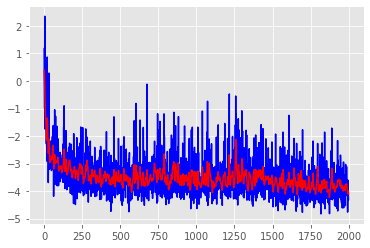

In [6]:
from scipy.ndimage.filters import gaussian_filter1d
ysmoothed = gaussian_filter1d(history.history['Negative Log Likelihood'], sigma=2)
plt.plot(history.history['Negative Log Likelihood'],'b')
plt.plot(ysmoothed, color = 'r')

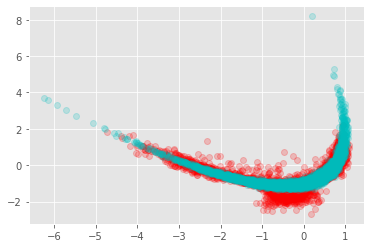

In [7]:
# Plot to make sure it worked
forward_pass = nvp(tf.random.normal([num_samples,3],mean=0.0,stddev=1.0))
plt.plot(forward_pass[:, 1], forward_pass[:, 2], 'ro', alpha=.2)
plt.plot(target_3d[:,1], target_3d[:,2], 'co', alpha = .2)

## Sampling $p(x|y)$ using triangular structure

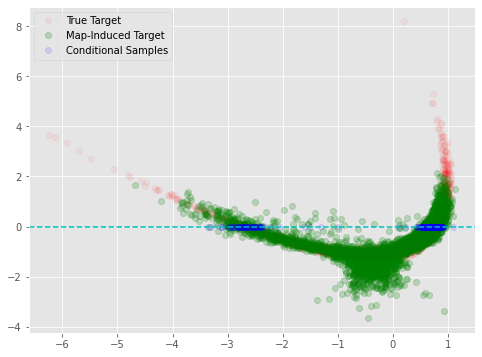

In [8]:
# We want to draw condition samples from about y = y^*
y_star = 0.0

ref_samps = tf.random.normal([5000,3],mean=0.0,stddev=1.0)
tgt_samps = nvp(ref_samps)

# Figure out what the value of r1 is
tgt_test = tf.concat([y_star*tf.ones([1,1]), tgt_samps[0:1,1:]], axis=1)
r1 = nvp.inverse(tgt_test)
r1 = float(r1[0,0])

# Now generate samples using the normalizing flow and fixed value of r1
cond_ref_samps = tf.concat([r1*tf.ones([500,1]), tf.random.normal([500,2],mean=0.0,stddev=1.0)], axis=1)
cond_tgt_samps = nvp(cond_ref_samps)

plt.figure(figsize=(8,6))
plt.plot(target_3d[:, 1], target_3d[:, 0], 'ro', alpha=.05, label='True Target')
plt.plot(tgt_samps[:, 1], tgt_samps[:, 0], 'go', alpha=.2, label='Map-Induced Target')
plt.plot(cond_tgt_samps[:, 1], cond_tgt_samps[:, 0], 'bo', alpha=.1, label='Conditional Samples')
plt.axhline(y=y_star, color='c', linestyle='--')
plt.legend(loc=2)
plt.show()